# Dirichlet mixtures of multinomials

This example notebook demonstrates the use a
Dirichlet mixture of multinomials
(a.k.a [Dirichlet-multinomial](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) or DM)
to model categorical count data.
Models like this one are important in a variety of areas, including
natural language processing, ecology, bioinformatics, and more.

Unlike the Multinomial distribution, in which the variance of counts is entirely
determined by the sample size and the probability of each category,
the DM has one additional parameter, the concentration, that controls this,
allowing us to model counts that are _more variable_ than the Multinomial
would predict&mdash;referred to as "over-dispersed".
The Dirichlet-multinomial can be understood as draws from the multinomial
but where each sample has a slightly different probability vector,
which is itself drawn from a common Dirichlet distribution.

Other examples of over-dispersed count distributions are the
[Beta-binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution)
(which can be thought of as a special case of the DM) or the
[Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)
distributions.

The DM is also an example of marginalizing
a mixture distribution over its latent parameters.
This notebook will demonstrate the performance benefits that come from
taking that approach.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import scipy.stats

In [2]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Simulation data

Let us simulate some over-dispersed, categorical count data
for this example.

Here we are simulating from the DM distribution itself,
so it is perhaps tautological to fit that model,
but rest assured that data like these really do appear in
the counts of different: (1) words in text corpuses, (2) types of RNA molecules in a cell, (3) items purchased by shoppers.

Here we will pretend that we have observed counts of five different
species of tree in a forest.

Our simulation will produce a two-dimensional matrix of integers (counts)
where each row, (zero-)indexed by $i \in (0...n-1)$, is an observation (different forest), and each
column $j \in (0...k-1)$ is a category (tree species).
We'll parameterize this distribution with three constants:
- $\mathrm{frac}$ : the expected fraction of each species,
  a $k$-dimensional vector on the simplex (i.e. sums-to-one)
- $\mathrm{total\_count}$ : the total number of items tallied in each observation,
- $\mathrm{conc}$ : the concentration, controlling the overdispersion of our data,
  where larger values result in our distribution more closely approximating the multinomial.
  
Each observation from the DM is simulated by:
1. first obtaining a value on the $k$-simplex simulated as
   $p_i \sim \mathrm{Dirichlet}(\alpha=\mathrm{conc} \times \mathrm{frac})$,
2. and then simulating $y_i \sim \mathrm{Multinomial}(\mathrm{total\_count}, p_i)$.

Notice that each observation gets its _own_
latent parameter $p_i$, simulated independently from
an identical Dirichlet distribution.

In [3]:
conc = 6.0
frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(frac)
n_samples = 10
total_count = 50

p = sp.stats.dirichlet(conc * frac).rvs(size=n_samples)
y = np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in p])

y

array([[33,  8,  4,  1,  4],
       [22, 28,  0,  0,  0],
       [35, 11,  2,  2,  0],
       [32,  1,  7, 10,  0],
       [24, 22,  4,  0,  0],
       [28, 13,  9,  0,  0],
       [19,  4, 21,  6,  0],
       [26, 17,  1,  6,  0],
       [32, 16,  0,  2,  0],
       [10, 30,  5,  5,  0]])

## Multinomial model

The first model that we will fit to these data is a plain
multinomial model, where the only parameter is the
expected frequency of each category, here referred to as
$a$, which we will give a Dirichlet prior.
If we have independent beliefs about what our
frequencies should be, we could encode this into our prior
on $a$, but the uniform prior works well.

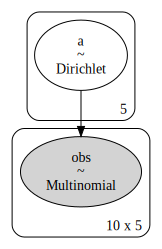

In [4]:
with pm.Model() as model_multinomial:
    a = pm.Dirichlet("a", a=np.ones(k))
    obs = pm.Multinomial("obs", n=total_count, p=a, shape=(n_samples, k), observed=y)

pm.model_to_graphviz(model_multinomial)

Interestingly, NUTS frequently runs into numerical problems on this model, perhaps an example of the
["Folk Theorem of Statistical Computing"](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/).

Because of a couple of identities of the multinomial distribution,
we can reparameterize this model in a number of ways&mdash;we
would obtain equivalent models by exploding our $n$ observations
of $\mathrm{total\_count}$ items into $(n \times \mathrm{total\_count})$
independent Bernoulli trials, or collapsing them down into
one Multinomial draw with $(n \times \mathrm{total\_count})$ items.
(Importantly, this is _not_ true for the DM distribution.)

While either of these would probably overcome the problems with the default sampler,
here we'll instead switch to a standard, Metropolis step method,
increasing our number of draws to overcome the inefficiency relative to NUTS.

In [5]:
with model_multinomial:
    trace_multinomial = pm.sample(
        draws=int(5e3), chains=4, step=pm.Metropolis(), return_inferencedata=True
    )

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.


Thankfully, we only get one warning, here about some evidence for inefficient sampling.

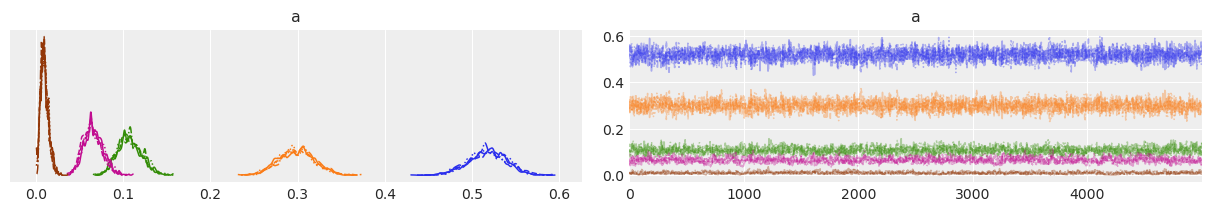

In [6]:
az.plot_trace(data=trace_multinomial, var_names=["a"], compact=True);

The trace plots look fairly good;
visually, each parameter appears to be moving around the posterior well,
although some sharp parts of the KDE plot suggests that
sampling sometimes gets stuck in one place for a few steps.

In [7]:
summary_multinomial = az.summary(trace_multinomial, var_names=["a"])
summary_multinomial = summary_multinomial.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_multinomial.posterior.sampling_time,
)

summary_multinomial

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.518,0.022,0.474,0.556,0.0,0.0,2020.0,2015.0,2028.0,2516.0,1.00,59.779073
a[1],0.299,0.021,0.261,0.338,0.0,0.0,1941.0,1941.0,1938.0,2310.0,1.00,57.441179
a[2],0.107,0.014,0.083,0.133,0.0,0.0,1259.0,1259.0,1257.0,1729.0,1.00,37.258343
a[3],0.066,0.011,0.046,0.087,0.0,0.0,767.0,767.0,734.0,1260.0,1.01,22.698292
a[4],0.010,0.005,0.003,0.019,0.0,0.0,516.0,516.0,457.0,538.0,1.01,15.270298


Likewise, diagnostics in the parameter summary table all look fine.
Here I've added a column estimating the effective sample size per
second of sampling.

Interestingly, because we know what each of the underlying tree
frequencies really are, we can see issues
with these inferences.

From above:

```
frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
```

Notice that the 94% HDIs _don't include the true values_ for
tree species 0, 2, 3.
We might have seen _one_ HDI miss, but _three_???

Let's take a look at how our data compare to the posterior predictive masses.

In [8]:
with model_multinomial:
    ppc = pm.fast_sample_posterior_predictive(
        trace=trace_multinomial,
        keep_size=True,
    )

# Concatenate with InferenceData object
trace_multinomial.extend(az.from_dict(posterior_predictive=ppc))

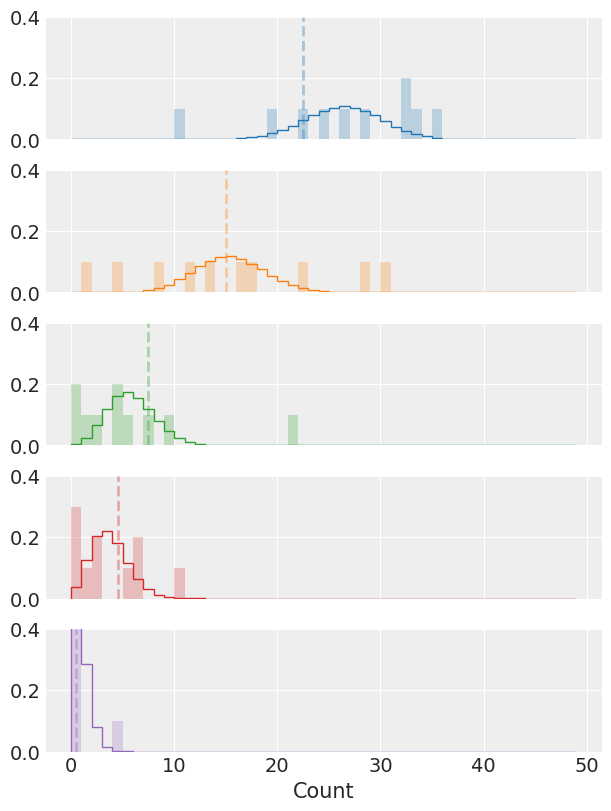

In [9]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(6, 8))
for j, ax in enumerate(axs):
    c = cmap(j)
    ax.hist(
        trace_multinomial.posterior_predictive.obs[:, :, :, j].values.flatten(),
        bins=np.arange(total_count),
        histtype="step",
        color=c,
        density=True,
    )
    ax.hist(
        trace_multinomial.observed_data.obs[:, j].values.flatten(),
        bins=np.arange(total_count),
        color=c,
        density=True,
        alpha=0.25,
    )
    ax.axvline(frac[j] * total_count, color=c, linestyle="--", lw=2, alpha=0.35)

axs[-1].set_xlabel("Count")
ax.set_ylim(0, 0.4);

Here we're plotting histograms of the predicted counts (profiles) against the observed counts (bars)
for each species (panels).

_(Notice that the y-axis isn't full height and clips the distributions for species-4 in purple.)_

And now we can start to see why our posterior HDIs missed the _true_ parameters for three of five species
(dashed lines).
See that for all of the species the observed counts are frequently quite far from the predictions
conditioned on the posterior distribution.
This is particularly obvious for species-2 (green) where we have one anomalous observation of more than 20
trees of this species, despite the posterior predicitive mass being concentrated far below that.

This is overdispersion at work, and a clear sign that we need to fix our model to accomodate it.

Posterior predictive checks are one of the best ways to diagnose model misspecification,
and this example is no different.

## Dirichlet-Multinomial Model - Explicit Mixture

Let's go ahead and model our data using the DM distribution.

For this model we'll keep the same prior on the expected frequencies of each
species, $a$.
We'll also add a strictly positive parameter, $\alpha$, for the concentration.

In this iteration of our model we'll explicitly include the latent multinomial
probability, $\pi_i$, modeling the $p_i$ from our simulations that we would never
observe in the real world.

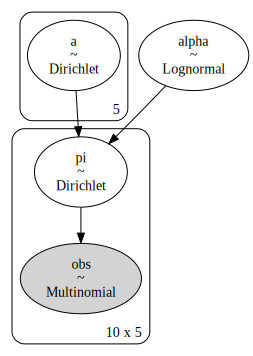

In [10]:
with pm.Model() as model_dm_explicit:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    pi = pm.Dirichlet("pi", a=a * alpha, shape=(n_samples, k))
    obs = pm.Multinomial("obs", n=total_count, p=pi, shape=(n_samples, k), observed=y)

pm.model_to_graphviz(model_dm_explicit)

Compare this diagram to the first.
The latent, Dirichlet distributed $\pi$ separating the multinomial
from the expected frequencies, $a$, accounts for
overdispersion of counts relative to the raw multinomial model.

In [11]:
with model_dm_explicit:
    trace_dm_explicit = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [pi, alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 185 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9041835811665464, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


We got a few warnings, although we'll ignore them for now.
More interesting is how much longer it took to sample this model than the
first.
This may be because our model has an additional ~$(n \times k)$ parameters,
but it seems like there are other geometric challenges for NUTS as well.

We'll see if we can fix these in the next model, but for now let's take a look at the traces.

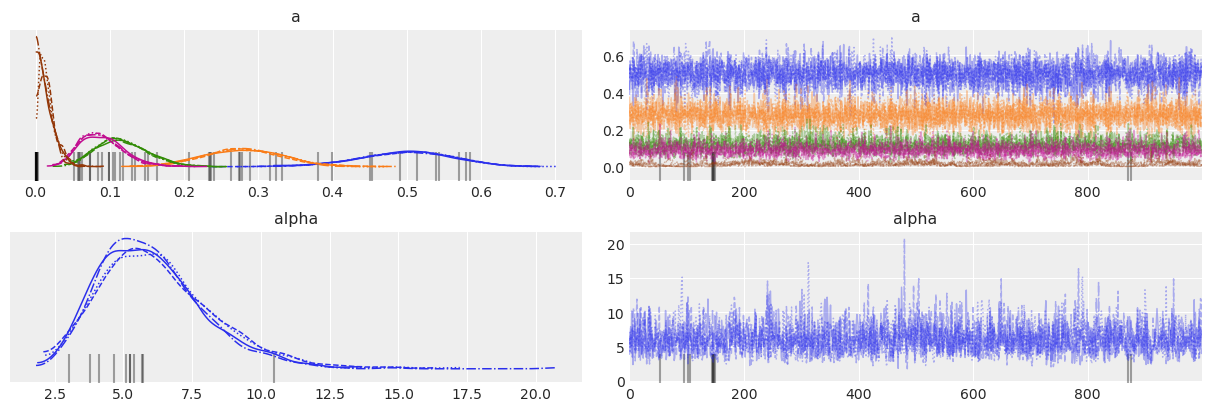

In [12]:
az.plot_trace(data=trace_dm_explicit, var_names=["a", "alpha"], compact=True);

Obviously some sampling issues, but it's hard to see where divergences are occurring.

In [13]:
summary_dm_explicit = az.summary(trace_dm_explicit, var_names=["a", "alpha"])
summary_dm_explicit = summary_dm_explicit.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_dm_explicit.posterior.sampling_time,
)

summary_dm_explicit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.499,0.063,0.378,0.613,0.001,0.001,4058.0,4058.0,4115.0,2871.0,1.00,21.881812
a[1],0.280,0.053,0.183,0.379,0.001,0.001,4549.0,4549.0,4506.0,2604.0,1.00,24.529414
a[2],0.117,0.034,0.057,0.182,0.001,0.000,3236.0,3236.0,3184.0,2919.0,1.00,17.449370
a[3],0.089,0.030,0.038,0.144,0.001,0.000,2721.0,2721.0,2605.0,2643.0,1.00,14.672353
a[4],0.015,0.011,0.001,0.036,0.001,0.001,163.0,163.0,112.0,120.0,1.03,0.878939
alpha,6.143,2.031,2.739,9.910,0.047,0.033,1857.0,1857.0,1799.0,2662.0,1.00,10.013436


Since we know the ground-truth for $a$ and $\alpha$ we can congratulate ourselves that
the HDIs include the true values for all of our parameters!

Modeling this mixture has made our inferences robust to the overdispersion of counts,
while the plain multinomial is very sensitive.
Notice that the HDI is much wider for each $a_i$.
In this case that makes the difference between correct and incorrect inferences.

This is great, but _we can do better_.
The larger $\hat{R}$ value for $a_4$ is concerning, and it's surprising
that our $\mathrm{ESS} \; \mathrm{sec}^{-1}$ is relatively small.

## Dirichlet-Multinomial Model - Marginalized

Happily, the Dirichlet distribution is conjugate to the multinomial
and therefore there's a convenient, closed-form for the marginalized
distribution, i.e. the DM distribution.

Let's marginalize out the explicit latent parameter, $\pi$,
replacing the combination of this node and the multinomial
with the DM to make an equivalent model.

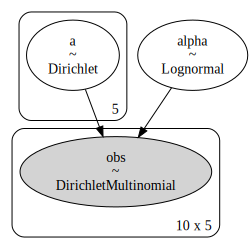

In [14]:
with pm.Model() as model_dm_marginalized:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    obs = pm.DirichletMultinomial(
        "obs", n=total_count, a=a * alpha, shape=(n_samples, k), observed=y
    )

pm.model_to_graphviz(model_dm_marginalized)

The plate diagram shows that we've collapsed the Dirichlet and the multinomial
nodes together into a single DM node.

In [15]:
with model_dm_marginalized:
    trace_dm_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


It samples quickly and without any of the warnings from before!

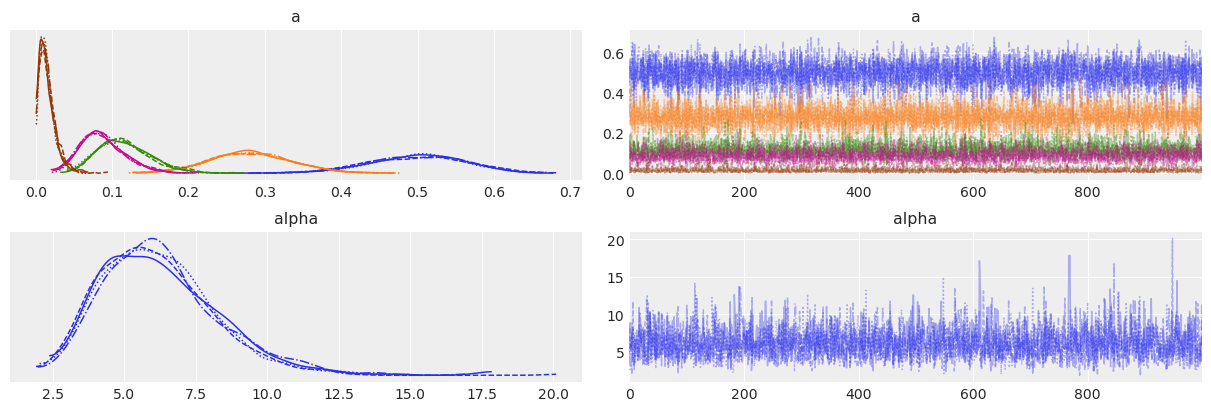

In [16]:
az.plot_trace(data=trace_dm_marginalized, var_names=["a", "alpha"], compact=True);

Trace plots look fuzzy and KDEs are clean.

In [17]:
summary_dm_marginalized = az.summary(trace_dm_marginalized, var_names=["a", "alpha"])
summary_dm_marginalized = summary_dm_marginalized.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_dm_marginalized.posterior.sampling_time,
)
assert all(summary_dm_marginalized.r_hat < 1.03)

summary_dm_marginalized

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.500,0.063,0.388,0.621,0.001,0.001,4543.0,4543.0,4609.0,2932.0,1.0,137.193022
a[1],0.282,0.054,0.177,0.381,0.001,0.001,6048.0,5875.0,6022.0,2937.0,1.0,182.642174
a[2],0.116,0.035,0.057,0.183,0.001,0.000,4317.0,4275.0,4229.0,3243.0,1.0,130.368100
a[3],0.087,0.029,0.035,0.143,0.001,0.000,2897.0,2897.0,2791.0,2580.0,1.0,87.485843
a[4],0.015,0.011,0.000,0.034,0.000,0.000,3064.0,2898.0,2685.0,2072.0,1.0,92.529038
alpha,6.213,2.032,2.692,9.812,0.037,0.027,3017.0,2866.0,3063.0,3303.0,1.0,91.109696


HDIs are very similar to the explicit model,
but $\hat{R}$ is close to $1$ everywhere
and $\mathrm{ESS} \; \mathrm{sec}^{-1}$ is much higher.
Our reparameterization (marginalization) has greatly improved the sampling!

This all looks very good, but what if we didn't have the ground-truth?

Posterior predictive checks to the rescue (again)!

In [18]:
with model_dm_marginalized:
    ppc = pm.fast_sample_posterior_predictive(trace_dm_marginalized, keep_size=True)

# Concatenate with InferenceData object
trace_dm_marginalized.extend(az.from_dict(posterior_predictive=ppc))

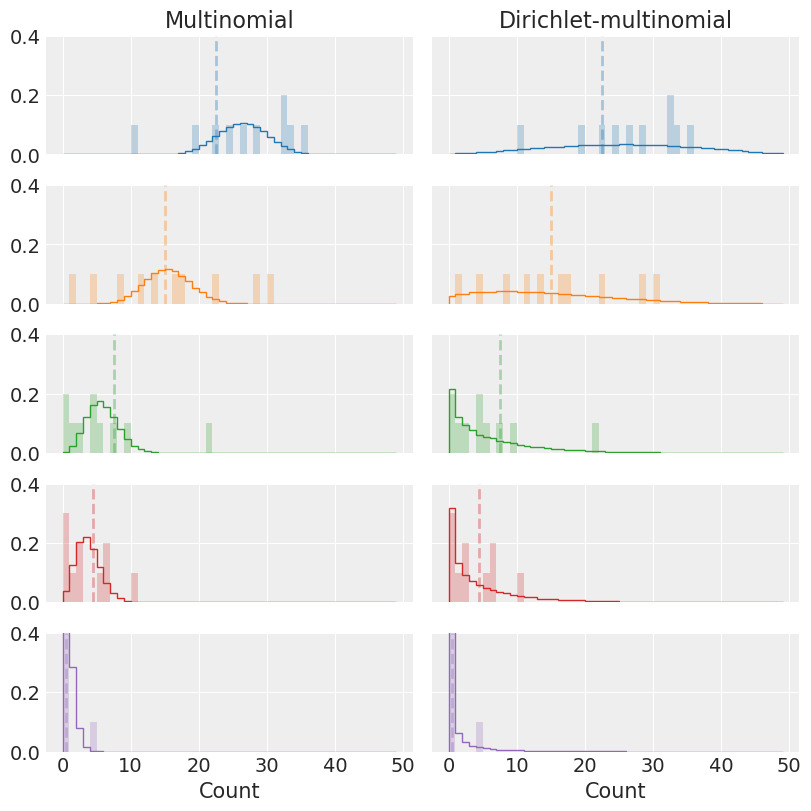

In [19]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 2, sharex=True, sharey=True, figsize=(8, 8))
for j, row in enumerate(axs):
    c = cmap(j)
    for _trace, ax in zip([trace_multinomial, trace_dm_marginalized], row):
        ax.hist(
            _trace.posterior_predictive.obs[:, :, :, j].values.flatten(),
            bins=np.arange(total_count),
            histtype="step",
            color=c,
            density=True,
        )
        ax.hist(
            _trace.observed_data.obs[:, j].values.flatten(),
            bins=np.arange(total_count),
            color=c,
            density=True,
            alpha=0.25,
        )
        ax.axvline(frac[j] * total_count, color=c, linestyle="--", lw=2, alpha=0.35)

axs[0, 0].set_title("Multinomial")
axs[0, 1].set_title("Dirichlet-multinomial")
axs[-1, 0].set_xlabel("Count")
axs[-1, 1].set_xlabel("Count")
ax.set_ylim(0, 0.4);

_(Notice, again, that the y-axis isn't full height, and clips the distributions for species-4 in purple.)_

Compared to the multinomial (plots on the left), PPCs for the DM (right) show that the observed data is
an entirely reasonable realization of our model.
This is great news!

## Model Comparison

Let's go a step further and try to put a number on how much better our DM model is
relative to the raw multinomial.
We'll use leave-one-out cross validation to compare the
out-of-sample predictive ability of the two.

In [20]:
az.compare(
    {"multinomial": trace_multinomial, "dirichlet_multinomial": trace_dm_marginalized}, ic="loo"
)

/Users/byronsmith/anaconda3/envs/pymc3-dev/lib/python3.9/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/byronsmith/anaconda3/envs/pymc3-dev/lib/python3.9/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dirichlet_multinomial,0,-96.382639,4.322324,0.000000,1.0,21.928336,0.000000,False,log
multinomial,1,-161.543594,24.431986,65.160955,0.0,5.506466,18.207668,True,log


Unsurprisingly, the DM outclasses the multinomial by a mile, assigning a weight of nearly
100% to the over-dispersed model.
We can conclude that between the two, the DM should be greatly favored for prediction,
parameter inference, etc.

## Conclusions

Obviously the DM is not a perfect model in every case, but it is often a better choice than the multinomial, much more robust while taking on just one additional parameter.

There are a number of shortcomings to the DM that we should keep in mind when selecting a model.
The biggest problem is that, while more flexible than the multinomial, the DM
still ignores the possibility of underlying correlations between categories.
If one of our tree species relies on another, for instance, the model we've used here
will not effectively account for this.
In that case, swapping the vanilla Dirichlet distribution for something fancier (e.g. the [Generalized Dirichlet](https://en.wikipedia.org/wiki/Generalized_Dirichlet_distribution) or [Logistic-Multivariate Normal](https://en.wikipedia.org/wiki/Logit-normal_distribution#Multivariate_generalization)) may be worth considering.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 23 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

json      : 2.0.9
matplotlib: 3.3.3
arviz     : 0.10.0
scipy     : 1.6.0
numpy     : 1.19.4
pymc3     : 3.10.0

Watermark: 2.1.0

